In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

from keras.models import Sequential
from keras.layers import Dense

from keras.models import Model
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Flatten
from keras import regularizers
from keras.layers.merge import concatenate

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.stats import ks_2samp

os.chdir('../src/')
import ml_analysis_plotting

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

The cell below accesses and orients the input arrays correctly

In [6]:
def  get_input_arrays(tree, features_list):
    array = np.transpose(tree.arrays(features_list, outputtype=tuple))
    print(array.shape)
    print(array[0])
    return array

def plot_dnn_features(arrays, features_list, nBins=25):   
    
    arrays_shape = arrays.shape
    print(arrays_shape)
    arrays = np.transpose(arrays)
    
    fig, ax = plt.subplots(int(arrays_shape[1]),3, figsize=(15, 9))
    print(arrays_shape[1])
    
    feature_n = 0
    
    for j in range(int(arrays_shape[1]/2.)):            
            
        for k in range(3):
            
            if feature_n <= arrays_shape[1] - 1:
                
                ax[j,k].hist(arrays[feature_n], bins=nBins)
                ax[j,k].set_title(features_list[feature_n])
                feature_n += 1
            else:
                break

In [7]:
os.chdir('../data')

In [8]:
tree = uproot.open('user.pavol.19077317._000001.reco_copy.root')[b'newtree;1']
tree.keys()

[b't_pt',
 b't_eta',
 b't_phi',
 b'tbar_pt',
 b'tbar_eta',
 b'tbar_phi',
 b'dilepton',
 b'lep_t_pt',
 b'lep_t_eta',
 b'lep_t_phi',
 b'lep_tbar_pt',
 b'lep_tbar_eta',
 b'lep_tbar_phi',
 b'nu_t_pt',
 b'nu_t_eta',
 b'nu_t_phi',
 b'nu_tbar_pt',
 b'nu_tbar_eta',
 b'nu_tbar_phi',
 b'ttbar_pt',
 b'kk']

In [9]:
features_list = tree.keys()[:-2]

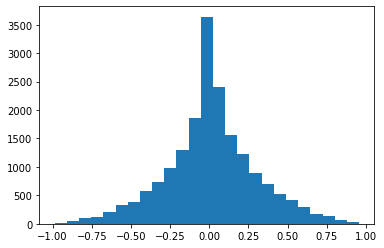

In [73]:
spin_target = tree.array(b'kk')
#pt_cut = np.where(spin_target/1000.0 < 300.)[0]
#spin_target = spin_target[pt_cut]
h,b,_=plt.hist(spin_target, bins=25)

### This scales the target in order for the ML to be successful

In [13]:
spin_transformer = RobustScaler()
spin_target_scaled = spin_transformer.fit_transform(spin_target.reshape(-1,1))
spin_target_scaled = (spin_target_scaled - np.min(spin_target_scaled))/(np.max(spin_target_scaled) - np.min(spin_target_scaled))
print(spin_target_scaled.shape)

(18732, 1)


In [14]:
features_array = get_input_arrays(tree, features_list)

(18732, 19)
[ 7.37026719e+04 -2.32636023e+00 -2.21447730e+00  1.61573406e+05
  8.32455397e-01  3.17241520e-01  1.00000000e+00  5.10136289e+04
 -1.21019089e+00 -2.41409278e+00  2.97444473e+04  4.01265115e-01
  2.66073322e+00  6.36220625e+04 -1.14657331e+00 -2.97279501e+00
  4.98950000e+04  9.59004343e-01 -5.63833117e-01]


In [15]:
np.where(np.isnan(features_array) == True)

(array([], dtype=int64), array([], dtype=int64))

In [17]:
transformer = RobustScaler()
features_array_scaled = transformer.fit_transform(features_array)
print(features_array_scaled.shape)

(18732, 19)


In [18]:
model = Sequential()
model.add(Dense(200, input_dim=len(features_list), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [19]:
'''
def multihead_model(features_list):

    t_input = Input(shape=(features_list), name="t_input")
    
    nu_input = Input(shape=(features_list), name="nu_input")
    
    t1 = Dense(200, activation="relu")(t_input)
    #x2 = Dropout(0.2)(x2)
    t2 = Dense(100, activation="relu")(t1)
    #x2 = Dropout(0.2)(x2)
    t3 = Dense(50, activation="relu")(t2)
    #x2 = Dropout(0.2)(x2)
    
    nu1 = Dense(200, activation="relu")(nu_input)
    #x2 = Dropout(0.2)(x2)
    nu2 = Dense(100, activation="relu")(nu1)
    #x2 = Dropout(0.2)(x2)
    nu3 = Dense(50, activation="relu")(nu2)
    #x2 = Dropout(0.2)(x2)

    x = concatenate([t3, nu3])

    x = Dense(25, activation="relu")(x)
    #x = Dropout(0.2)(x)
    #x = Dense(32, activation="relu")(x)
    #x = Dropout(0.2)(x)

    output = Dense(1, activation="sigmoid", name="main_output")(x)

    model = Model(inputs=[t_input, nu_input], outputs=output)

    return model
'''

'\ndef multihead_model(features_list):\n\n    t_input = Input(shape=(features_list), name="t_input")\n    \n    nu_input = Input(shape=(features_list), name="nu_input")\n    \n    t1 = Dense(200, activation="relu")(t_input)\n    #x2 = Dropout(0.2)(x2)\n    t2 = Dense(100, activation="relu")(t1)\n    #x2 = Dropout(0.2)(x2)\n    t3 = Dense(50, activation="relu")(t2)\n    #x2 = Dropout(0.2)(x2)\n    \n    nu1 = Dense(200, activation="relu")(nu_input)\n    #x2 = Dropout(0.2)(x2)\n    nu2 = Dense(100, activation="relu")(nu1)\n    #x2 = Dropout(0.2)(x2)\n    nu3 = Dense(50, activation="relu")(nu2)\n    #x2 = Dropout(0.2)(x2)\n\n    x = concatenate([t3, nu3])\n\n    x = Dense(25, activation="relu")(x)\n    #x = Dropout(0.2)(x)\n    #x = Dense(32, activation="relu")(x)\n    #x = Dropout(0.2)(x)\n\n    output = Dense(1, activation="sigmoid", name="main_output")(x)\n\n    model = Model(inputs=[t_input, nu_input], outputs=output)\n\n    return model\n'

In [20]:
#model = multihead_model(features_list)

In [21]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [22]:
features_array_scaled, spin_target_scaled = shuffle(features_array_scaled, spin_target_scaled)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features_array_scaled, spin_target_scaled, test_size=0.2)

## If you don't redefine/compile/build the model, the weights are 'updated' from the previous training

In [52]:
history = model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=2, validation_split=.2)
'''
histories = []
for i in range(10):
    print("Epoch: "+str(int(i*50+1)))
    history = model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=2, validation_split=.1)
    print("Evaluating:")
    print(model.evaluate(X_test, y_test))
    histories.append(history.history['loss'])
'''

Train on 11988 samples, validate on 2997 samples
Epoch 1/200
 - 2s - loss: 0.0795 - mae: 0.0795 - val_loss: 0.0735 - val_mae: 0.0735
Epoch 2/200
 - 2s - loss: 0.0798 - mae: 0.0798 - val_loss: 0.0743 - val_mae: 0.0743
Epoch 3/200
 - 2s - loss: 0.0784 - mae: 0.0784 - val_loss: 0.0744 - val_mae: 0.0744
Epoch 4/200
 - 2s - loss: 0.0794 - mae: 0.0794 - val_loss: 0.0755 - val_mae: 0.0755
Epoch 5/200
 - 2s - loss: 0.0789 - mae: 0.0789 - val_loss: 0.0759 - val_mae: 0.0759
Epoch 6/200
 - 2s - loss: 0.0785 - mae: 0.0785 - val_loss: 0.0736 - val_mae: 0.0736
Epoch 7/200
 - 2s - loss: 0.0791 - mae: 0.0791 - val_loss: 0.0731 - val_mae: 0.0731
Epoch 8/200
 - 2s - loss: 0.0787 - mae: 0.0787 - val_loss: 0.0726 - val_mae: 0.0726
Epoch 9/200
 - 2s - loss: 0.0790 - mae: 0.0790 - val_loss: 0.0739 - val_mae: 0.0739
Epoch 10/200
 - 2s - loss: 0.0795 - mae: 0.0795 - val_loss: 0.0795 - val_mae: 0.0795
Epoch 11/200
 - 2s - loss: 0.0791 - mae: 0.0791 - val_loss: 0.0747 - val_mae: 0.0747
Epoch 12/200
 - 2s - loss

'\nhistories = []\nfor i in range(10):\n    print("Epoch: "+str(int(i*50+1)))\n    history = model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=2, validation_split=.1)\n    print("Evaluating:")\n    print(model.evaluate(X_test, y_test))\n    histories.append(history.history[\'loss\'])\n'

In [53]:
model.save_weights('model_weights.h5')

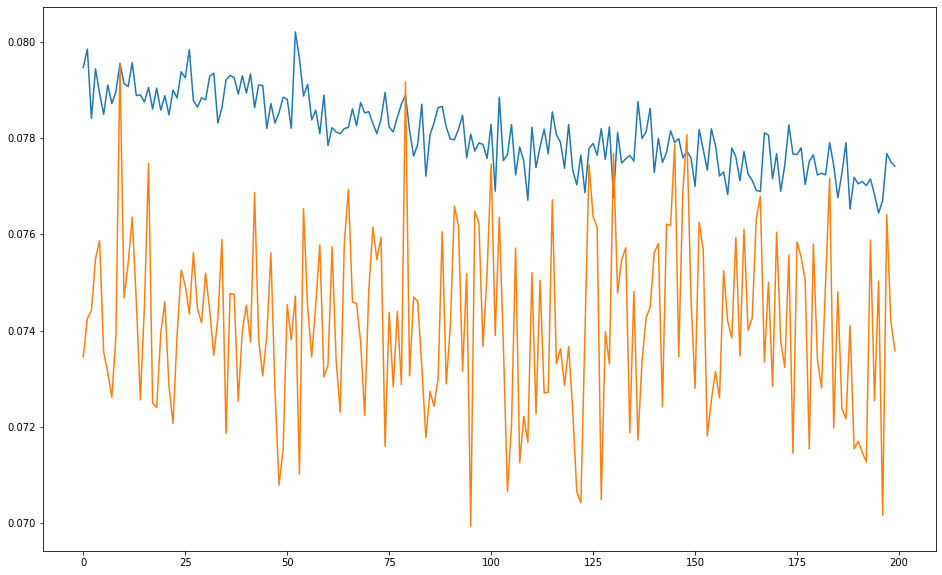

In [54]:
fig, ax = plt.subplots(figsize=(16, 10))
'''
for i in range(1):
    plt.scatter(range(len(histories[i])), histories[i])
'''
#history_hist = plt.hist(history.history['loss'], bins=50)
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
plt.show()

In [55]:
y_pred = model.predict(X_test)
print(model.evaluate(X_test, y_test))

3747/3747 [==============================] - 0s 14us/step
[0.07284298678251117, 0.07284299284219742]


In [78]:
class make_hist_dicts:

    def correct_compare_hist(self,
        array1, array2, nBins=40, normed=False, gauss=False, logY=False
    ):
        array1_dict = {"hist":None, "binx":None, "weights":None, "binDx":None}
        array2_dict = {"hist":None, "binx":None, "weights":None, "binDx":None}

        array1 = self.removeNan(array1)
        array2 = self.removeNan(array2)

        if gauss is True:
            ratio = guassian_comparison_ratio(array1, array2, nBins)
        else:
            ratio = np.ones(nBins)
        
        hist1, bins1, hist2, bins2 = self.get_hists(array2, array1, nBins)
        
        stat = np.round(ks_2samp(plt.hist(array1, bins=nBins)[0], plt.hist(array2, bins=nBins)[0]), 4)
        plt.close()
        b1 = np.zeros(len(hist1))
        w1 = np.zeros(len(hist1))
        for i in range(len(hist1)):
            b1[i] = (bins1[i + 1] + bins1[i]) / 2
            w1[i] = bins1[i + 1] - bins1[i]
        b2 = b1
        w2 = w1
        
        array1_dict["binDx"] = w1
        array2_dict["binDx"] = w2
        
        array1_dict["hist"] = hist1
        array2_dict["hist"] = hist2
        
        array1_dict["binx"] = b1
        array2_dict["binx"] = b2
        
        hist1 = np.multiply(hist1, ratio)
        hist2 = np.multiply(hist2, ratio)

        weights1 = self.get_weights(array1, bins1, ratio)
        weights2 = self.get_weights(array2, bins2, ratio)
        
        array1_dict["weights"] = weights1
        array2_dict["weights"] = weights2

        if normed is False:
            scale1 = np.maximum(np.max(hist1), np.max(hist2))
            scale2 = scale1
        else:
            scale1 = np.max(hist1)
            scale2 = np.max(hist2)
        
        #error = hist2/len(array2)
        error = 1./hist2    
        fig, ax = plt.subplots(figsize=(16, 10))
        plt.cla()
        if logY is True:
            ax.set_yscale("log")
        ax.set_title("Regression Analysis - model 3, Batches", fontsize=35)
        ax.set_xlabel("kk", fontsize=24)
        ax.set_ylabel("Arbitraty Units", fontsize=24)
        plt.bar(b1, hist1 / scale1, width=w1, alpha=0.2, color="blue", label="Truth")
        plt.bar(b2, hist2 / scale2, width=w2, yerr=error, alpha=0.2, color="red", label="Prediction")
        plt.bar(
            b1,
            hist1 / scale1,
            width=w1,
            alpha=1.0,
            color="none",
            edgecolor="blue",
            linewidth=2.0,
        )
        plt.bar(
            b2,
            hist2 / scale2,
            width=w2,
            alpha=1.0,
            color="none",
            edgecolor="red",
            linewidth=2.0,
        )
        plt.annotate("Kolmogorov–Smirnov", (.7,.94), fontsize=24)
        plt.annotate("Statistic: "+str(stat[0]), (.75,.87), fontsize=24)
        plt.annotate("P-value: "+str(stat[1]), (.75,.80), fontsize=24)
        plt.legend(fontsize=24)
        plt.ylim(0,1.2)
        plt.show()
        
        return array1_dict, array2_dict, ratio

    def removeNan(self,array):
        if len(np.where(np.isnan(array) is True)) == 0:
            pass
        return array[np.logical_not(np.isnan(array))]

    def get_hists(self, array1, array2, nBins):

        """
        array1 = (
            2 * (array1 - np.min(array1)) / (np.max(array1) - np.min(array1)) - 1
        )
        array2 = (
            2 * (array2 - np.min(array2)) / (np.max(array2) - np.min(array2)) - 1
        )
        """

        hist1, bins1, _ = plt.hist(
            array2, color="blue", alpha=0.2, bins=nBins
        )  # , weights=true_z_w)
        plt.close()
        bins2 = bins1
        hist2 = np.zeros(len(hist1))

        # z_reg = np.multiply(test_z_torch.data.numpy().reshape(1000), test_z_w)
        # z_reg = test_z_torch.data.numpy().reshape(len(true_z))
        # z_reg = test_z_torch

        for i in range(len(hist1)):
            hist2[i] = len(
                np.where(array1[np.where((array1 <= bins1[i + 1]))[0]] > bins1[i])[0]
            )  # & (z_reg > bins1[i])[0])]))
            if i == len(hist1):
                hist2[i] = len(np.where(array1 >= bins1[i])[0])
        return hist1, bins1, hist2, bins2

    def get_weights(self, array, bins, ratio):

        weights = np.zeros(len(array))
        bins = np.digitize(array, bins)

        for i in range(len(ratio)):
            weights[np.where(bins == i)] = ratio[i]

        return weights

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


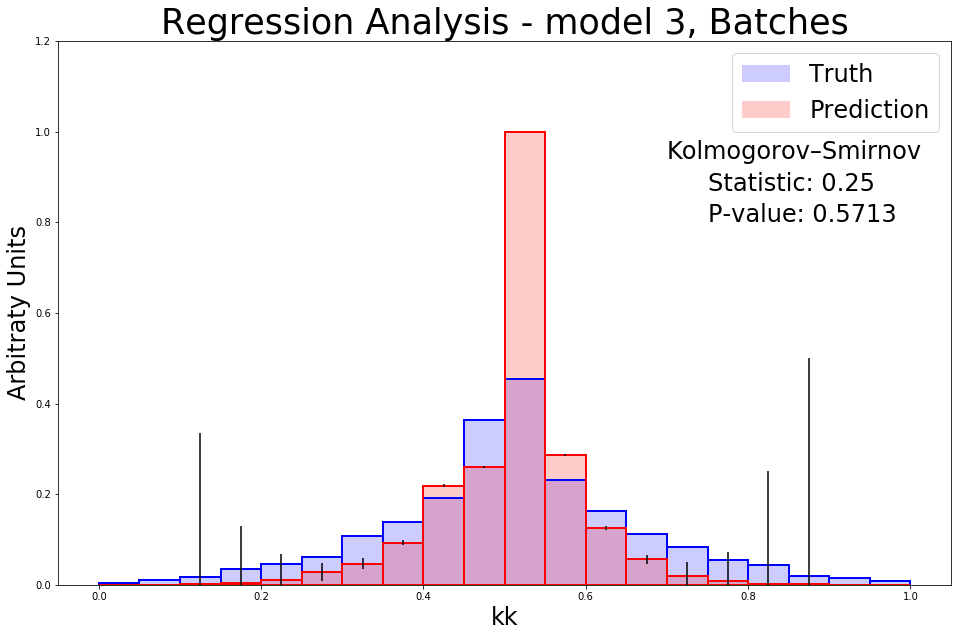

In [79]:
y_y = spin_transformer.fit_transform(y_test.reshape(-1,1))
y_y = (y_y - np.min(y_y))/(np.max(y_y) - np.min(y_y))
comp = make_hist_dicts()
hist1, hist2, ratio = comp.correct_compare_hist(y_y, y_pred, nBins=20)

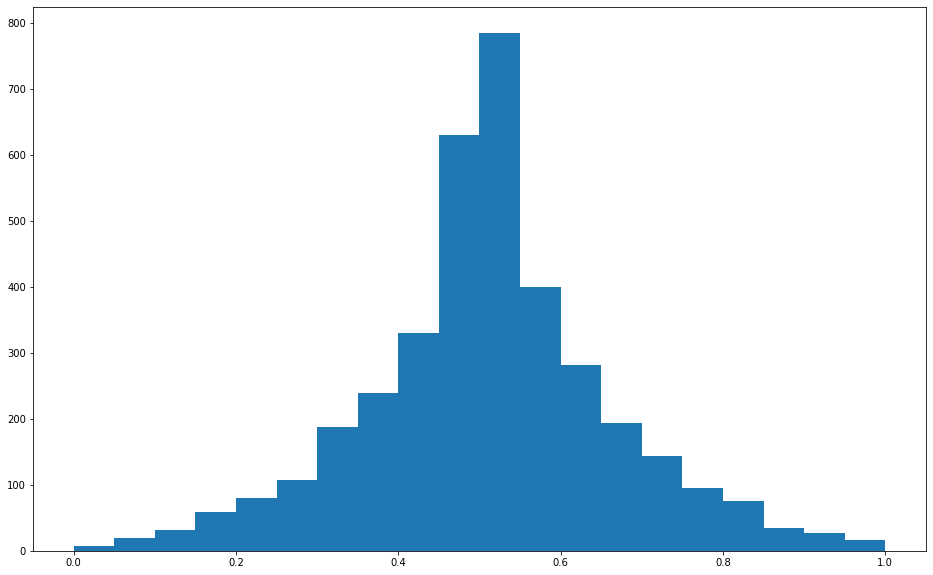

In [75]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.hist(y_y,bins=20)
#plt.hist(y_pred,bins=20,alpha=.5)
plt.show()

In [67]:
print(model.predict(X_test))

[[0.45035216]
 [0.53333443]
 [0.443147  ]
 ...
 [0.47772497]
 [0.5071553 ]
 [0.5069426 ]]
